# Proyek Klasifikasi Gambar : Klasifikasi Jenis Bola
#### Klasifikasi 15 jenis bola, sumber dataset dari Kaggle : https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification/data (dan hasil scrapping dari berbagai sumber)
1. Nama : Hartmann Kanisius Galla' Massang
2. Email : kanismassang@gmail.com
3. ID Dicoding : hartmannkkk

## Import Library

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-02-09 12:16:20.469755: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 12:16:20.704533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739074580.781262   15955 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739074580.799737   15955 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 12:16:21.007010: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Data Preparation and Exploration

In [2]:
path_dir = '/home/arthamna/Jupyter notebook/Dicoding Intermediate/Tugas Akhir/train'

# Membuat list kosong untuk path dan label
filepaths = []
labels = []

folds = os.listdir(path_dir)

for fold in folds:
    foldpath = os.path.join(path_dir, fold)
    
    files = os.listdir(foldpath)
    for f in files:
        fpath = os.path.join(foldpath, f)
        
        filepaths.append(fpath)
        labels.append(fold)
        
init_df = pd.DataFrame(data={'filepaths':filepaths, 'labels':labels})
init_df

,filepaths,labels
0,/home/arthamna/Jupyter notebook/Dicoding Inter...,hockey_ball
1,/home/arthamna/Jupyter notebook/Dicoding Inter...,hockey_ball
2,/home/arthamna/Jupyter notebook/Dicoding Inter...,hockey_ball
3,/home/arthamna/Jupyter notebook/Dicoding Inter...,hockey_ball
4,/home/arthamna/Jupyter notebook/Dicoding Inter...,hockey_ball
...,...,...
10241,/home/arthamna/Jupyter notebook/Dicoding Inter...,baseball
10242,/home/arthamna/Jupyter notebook/Dicoding Inter...,baseball
10243,/home/arthamna/Jupyter notebook/Dicoding Inter...,baseball
10244,/home/arthamna/Jupyter notebook/Dicoding Inter...,baseball


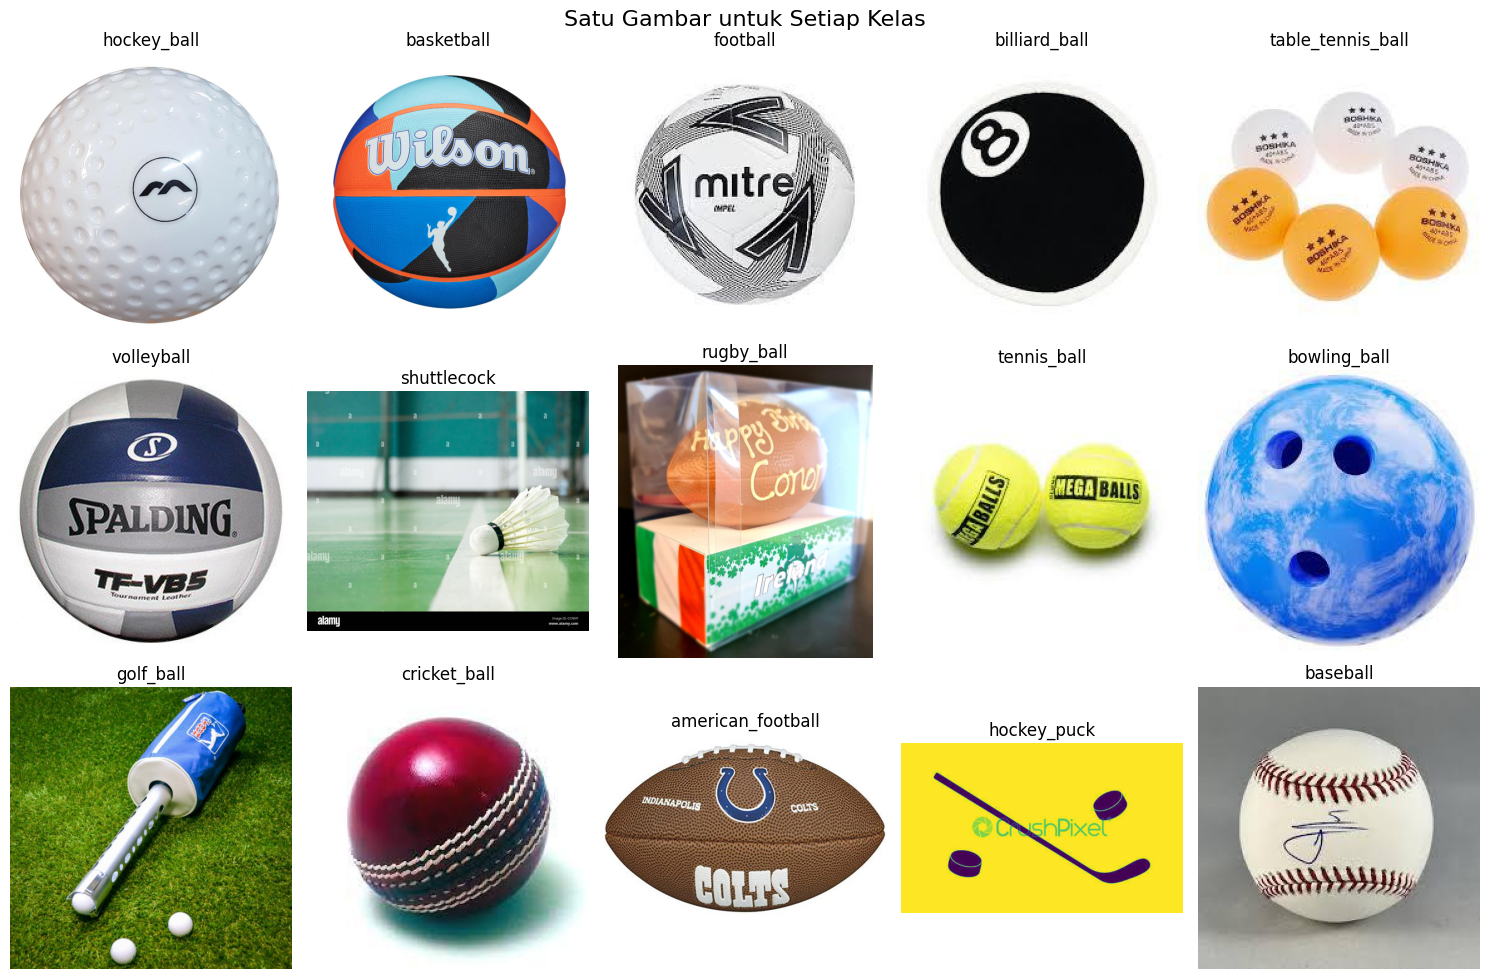

In [8]:
import random
import matplotlib.pyplot as plt
from PIL import Image

unique_classes = init_df['labels'].unique()
# Inisiasi dictionary untuk menyimpan gambar sampel tiap kelas
sample_images = {}

# Loop untuk tiap kelas unik
for class_label in unique_classes:
    df_class = init_df[init_df['labels'] == class_label]
    # Pilih satu baris secara acak dari dataframe kelas tersebut, beri label, tampilkan jika cukup
    random_row = df_class.sample(n=1).iloc[0]
    image = Image.open(random_row['filepaths'])
    sample_images[class_label] = image
    if len(sample_images) == 15:
        break

# Plot gambar
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
fig.suptitle('Satu Gambar untuk Setiap Kelas', fontsize=16)

for idx, (class_label, image) in enumerate(sample_images.items()):
    ax = axes[idx // 5, idx % 5]
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(class_label)

plt.tight_layout()
plt.show()


In [3]:
class_df = (init_df['labels'].value_counts(normalize=True) * 100) 
class_percentages =class_df.map(lambda x: f"{x:.2f}%")
print("\nPersentase data per kelas:")
print(class_percentages)


Persentase data per kelas:
labels
basketball           8.59%
tennis_ball          8.44%
american_football    8.31%
billiard_ball        7.89%
table_tennis_ball    7.57%
football             7.37%
cricket_ball         7.10%
golf_ball            6.71%
hockey_ball          6.47%
rugby_ball           6.02%
bowling_ball         5.38%
volleyball           5.28%
shuttlecock          5.24%
baseball             4.88%
hockey_puck          4.76%
Name: proportion, dtype: object


Data sedikit tidak berimbang, saya memutuskan menggunakan class_weight untuk mengatasinya.

## Preprocessing, Training, Plot

In [4]:
# Bagi data berdasarkan untuk train dan testing, 80 : 20
seed = 42
train_df, test_df = train_test_split(init_df, test_size=0.2, random_state=seed)

In [5]:
from tensorflow.keras.applications.resnet50 import preprocess_input
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
) # ternyata wajib sama dengan train_data untuk memudahkan validasi

train_gen = train_datagen.flow_from_dataframe(train_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=(224, 224),
                                       color_mode='rgb',
                                       class_mode='categorical' ,
                                       batch_size=64)

test_gen = test_datagen.flow_from_dataframe(test_df,
                                      x_col='filepaths',
                                      y_col='labels',
                                      target_size=(224, 224),
                                      color_mode='rgb',
                                      class_mode='categorical',
                                      batch_size=64)

Found 8189 validated image filenames belonging to 15 classes.
Found 2050 validated image filenames belonging to 15 classes.


/home/arthamna/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 7 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D,
    Dense, Dropout, BatchNormalization, LeakyReLU, Concatenate
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import register_keras_serializable
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Buat fungsi custom untuk menghentikan pelatihan setelah mencapai target
class TerminateOnTargetAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target=0.95):
        super(TerminateOnTargetAccuracy, self).__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if acc is not None and val_acc is not None:
            if acc >= self.target and val_acc >= self.target:
                print(f"\nEpoch {epoch+1}: mencapai akurasi minimal {self.target*100:.0f}% di training dan validasi. Pelatihan dihentikan. ")
                self.model.stop_training = True

class_counts = init_df['labels'].value_counts()
total = class_counts.sum()
class_weights = {i: total/(len(class_counts)*count) for i, count in enumerate(class_counts)}

# Fungsi custom yang menggabungkan pendekatan average dan max pooling
@register_keras_serializable()
class GlobalPoolingConcatenate(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GlobalPoolingConcatenate, self).__init__(**kwargs)
        self.avg_pool = GlobalAveragePooling2D()
        self.max_pool = GlobalMaxPooling2D()
        
    def call(self, inputs):
        avg_pool_output = self.avg_pool(inputs)
        max_pool_output = self.max_pool(inputs)
        return tf.concat([avg_pool_output, max_pool_output], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        return config
def create_hybrid_model(input_shape=(224, 224, 3), num_classes=15):
    # Pretrained
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape
    )
    base_model.trainable = False 

    # model Sequential
    model = Sequential([
        base_model,

        Conv2D(512, (3,3), padding='same', activation='swish'),
        BatchNormalization(),
        MaxPooling2D(2),
        Dropout(0.5),

        GlobalPoolingConcatenate(),
        Dense(512, activation='swish', kernel_regularizer=l2(1e-3)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.AdamW(
        learning_rate=0.00085,
        weight_decay=0.001
    )
    
    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.15) # Kurangi overfitting di akurasi
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=['accuracy']
    )

    return model

def train_with_strategy(model, train_gen, test_gen):

    history = model.fit(
        train_gen,
        validation_data=test_gen,
        epochs=17,
        class_weight=class_weights,
        callbacks=[
            TerminateOnTargetAccuracy(target=0.95),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6),
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
        ]
    )
    return model, history

def fine_tune_model(model):
    # Unfreeze layer atas ; fine-tuning
    model.layers[0].trainable = True
    for layer in model.layers[0].layers[:110]: # Jumlah layer terbaik untuk unfreeze berdasarkan eksperimen
        layer.trainable = False  

    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.15),
        metrics=['accuracy']
    )

    history2 = model.fit(
        train_gen,
        validation_data=test_gen,
        epochs=20,
        class_weight=class_weights,
        callbacks=[
            TerminateOnTargetAccuracy(target=0.95),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2)
        ]
    )
    return model, history2



In [9]:
model = create_hybrid_model()
trained_model, history = train_with_strategy(model, train_gen, test_gen)
# Fine-tuning
model_fn, history2 = fine_tune_model(trained_model)

I0000 00:00:1739074902.899722   15955 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/arthamna/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/17


I0000 00:00:1739074911.759569   16375 service.cc:148] XLA service 0x7f55ac013ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739074911.759782   16375 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-02-09 12:21:52.066729: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739074913.039113   16375 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1739074923.417708   16375 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 20/128 ━━━━━━━━━━━━━━━━━━━━ 51s 474ms/step - accuracy: 0.1250 - loss: 5.0607

/home/arthamna/miniconda3/envs/tf/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 30/128 ━━━━━━━━━━━━━━━━━━━━ 14:33 9s/step - accuracy: 0.1747 - loss: 4.7869  

2025-02-09 12:26:24.922876: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6997', 12 bytes spill stores, 12 bytes spill loads



128/128 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.3942 - loss: 3.7107 - val_accuracy: 0.7927 - val_loss: 2.1601 - learning_rate: 8.5000e-04
Epoch 2/17
128/128 ━━━━━━━━━━━━━━━━━━━━ 57s 442ms/step - accuracy: 0.6999 - loss: 2.3443 - val_accuracy: 0.8312 - val_loss: 1.8396 - learning_rate: 8.5000e-04
Epoch 3/17
128/128 ━━━━━━━━━━━━━━━━━━━━ 56s 438ms/step - accuracy: 0.7774 - loss: 2.0497 - val_accuracy: 0.8220 - val_loss: 1.7822 - learning_rate: 8.5000e-04
Epoch 4/17
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 433ms/step - accuracy: 0.8159 - loss: 1.8761 - val_accuracy: 0.8820 - val_loss: 1.6418 - learning_rate: 8.5000e-04
Epoch 5/17
128/128 ━━━━━━━━━━━━━━━━━━━━ 56s 434ms/step - accuracy: 0.8494 - loss: 1.7281 - val_accuracy: 0.8800 - val_loss: 1.5947 - learning_rate: 8.5000e-04
Epoch 6/17
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 432ms/step - accuracy: 0.8690 - loss: 1.6005 - val_accuracy: 0.8932 - val_loss: 1.5297 - learning_rate: 8.5000e-04
Epoch 7/17
128/128 ━━━━━━━━━━━━━━━━━━━━ 56s 440ms/step - ac

2025-02-09 12:42:37.071229: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-09 12:42:43.272877: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[2048,1,1,1024]{3,2,1,0}, u8[0]{0}) custom-call(f16[64,14,14,1024]{3,2,1,0}, f16[64,7,7,2048]{3,2,1,0}), window={size=1x1 stride=2x2}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-09 12:42:43.679540: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation

 75/128 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step - accuracy: 0.9470 - loss: 1.1311

2025-02-09 12:43:25.418014: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-09 12:43:29.572979: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[256,3,3,256]{3,2,1,0}, u8[0]{0}) custom-call(f16[63,14,14,256]{3,2,1,0}, f16[63,14,14,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-02-09 12:43:30.045084: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation 

128/128 ━━━━━━━━━━━━━━━━━━━━ 109s 623ms/step - accuracy: 0.9469 - loss: 1.1283 - val_accuracy: 0.9200 - val_loss: 1.1899 - learning_rate: 1.0000e-04
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 55s 429ms/step - accuracy: 0.9712 - loss: 1.0668 - val_accuracy: 0.9439 - val_loss: 1.1212 - learning_rate: 1.0000e-04
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.9805 - loss: 1.0314 
Epoch 3: mencapai akurasi minimal 95% di training dan validasi. Pelatihan dihentikan. 
128/128 ━━━━━━━━━━━━━━━━━━━━ 56s 435ms/step - accuracy: 0.9805 - loss: 1.0314 - val_accuracy: 0.9512 - val_loss: 1.0963 - learning_rate: 1.0000e-04


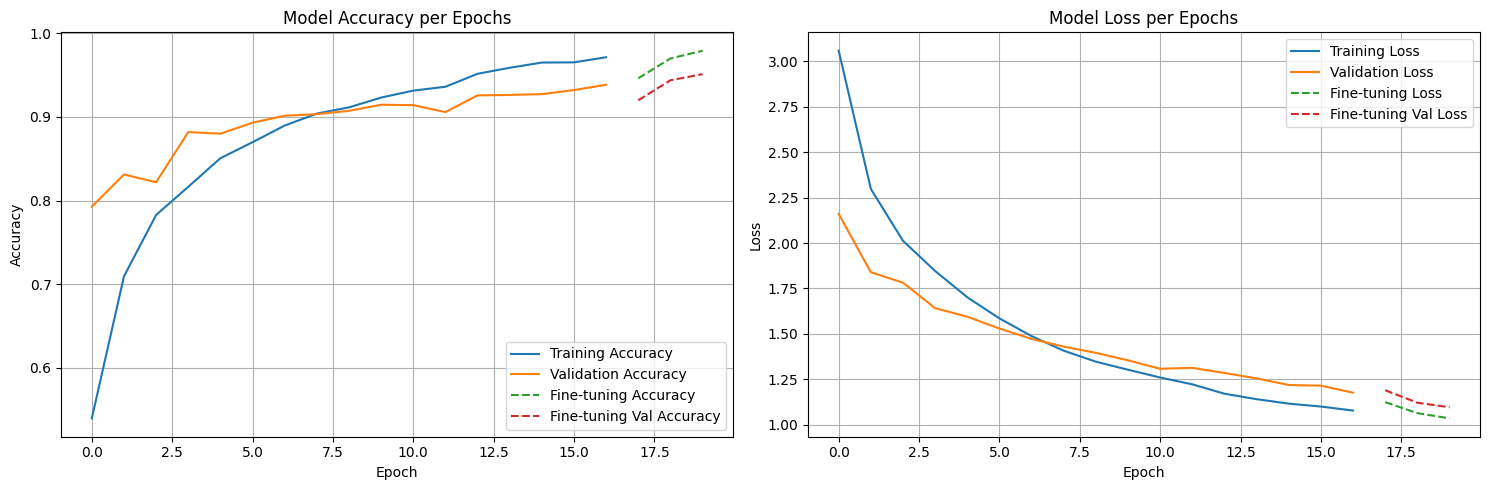

In [12]:
import matplotlib.pyplot as plt

def plot_training_history(history1, history2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot akurasi
    ax1.plot(history1.history['accuracy'], label='Training Accuracy')
    ax1.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    if history2:
        start = len(history1.history['accuracy'])
        ax1.plot(range(start, start + len(history2.history['accuracy'])), 
                history2.history['accuracy'], '--', label='Fine-tuning Accuracy')
        ax1.plot(range(start, start + len(history2.history['val_accuracy'])), 
                history2.history['val_accuracy'], '--', label='Fine-tuning Val Accuracy')
    ax1.set_title('Model Accuracy per Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history1.history['loss'], label='Training Loss')
    ax2.plot(history1.history['val_loss'], label='Validation Loss')
    if history2:
        start = len(history1.history['loss'])
        ax2.plot(range(start, start + len(history2.history['loss'])), 
                history2.history['loss'], '--', label='Fine-tuning Loss')
        ax2.plot(range(start, start + len(history2.history['val_loss'])), 
                history2.history['val_loss'], '--', label='Fine-tuning Val Loss')
    ax2.set_title('Model Loss per Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history, history2)  

In [19]:
import tensorflow as tf
import tensorflowjs as tfjs
import os

def save_all_model_formats(model, base_path='saved_models_2'):
    os.makedirs(base_path, exist_ok=True)

    # 1. Simpan SavedModel (format .pb + variables)
    saved_model_dir = os.path.join(base_path, 'saved_model')
    model.export(saved_model_dir) 
    print(f"SavedModel disimpan di: {saved_model_dir}")

    # 2. Simpan TFLite
    tflite_dir = os.path.join(base_path, 'tflite')
    os.makedirs(tflite_dir, exist_ok=True)
    
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    tflite_path = os.path.join(tflite_dir, 'model.tflite')
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    
    # Simpan label.txt (ternyata harus manual
    class_names = init_df['labels'].unique() 
    label_path = os.path.join(tflite_dir, 'label.txt')
    with open(label_path, 'w') as f:
        f.write("\n".join(class_names))
    
    print(f"Model TFLite disimpan di: {tflite_path}")

    # 3. Simpan TFJS
    tfjs_dir = os.path.join(base_path, 'tfjs_model')
    tfjs.converters.save_keras_model(model, tfjs_dir)
    print(f"Model TFJS disimpan di: {tfjs_dir}")

    return {
        'tflite_path': tflite_path,
        'tfjs_path': tfjs_dir,
        'saved_model_dir': saved_model_dir
    }

model_paths = save_all_model_formats(model)

INFO:tensorflow:Assets written to: saved_models_2/saved_model/assets


INFO:tensorflow:Assets written to: saved_models_2/saved_model/assets


Saved artifact at 'saved_models_2/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  140482341914576: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140482341913696: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140482415161264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415162144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415163904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415160032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415163024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415163728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415495648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415497936: TensorSpec(shape=(), dtype=tf.reso

INFO:tensorflow:Assets written to: /tmp/tmpei204dsx/assets


Saved artifact at '/tmp/tmpei204dsx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  140482341914576: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140482341913696: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140482415161264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415162144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415163904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415160032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415163024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415163728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415495648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140482415497936: TensorSpec(shape=(), dtype=tf.resource, name

W0000 00:00:1738849047.717302   57649 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1738849047.717341   57649 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-06 21:37:27.717535: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpei204dsx
2025-02-06 21:37:27.730102: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-06 21:37:27.730129: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpei204dsx
2025-02-06 21:37:27.849830: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-06 21:37:28.481003: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpei204dsx
2025-02-06 21:37:28.631560: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 914029 microseconds.


Model TFLite disimpan di: saved_models_2/tflite/model.tflite
failed to lookup keras version from the file,
    this is likely a weight only file
weight normalization/count with shape () and dtype int64 was auto converted to the type int32
Model TFJS disimpan di: saved_models_2/tfjs_model


## Tambahan : Prediksi / Inference, List Resolusi , List Req

In [45]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os

class BallClassifier:
    def __init__(self, model_path):
        self.classes = init_df['labels'].unique()
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        # Dapatkan detail input dan output
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        
        # Ukuran input sesuai model
        self.input_shape = (224, 224)
    
    def preprocess_image(self, image_path):
        img = tf.keras.preprocessing.image.load_img(
            image_path, 
            target_size=self.input_shape
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        # preprocessing sesuai training, resnet
        preprocessed = preprocess_input(img_array)
        
        return preprocessed
    
    def predict(self, image_path):
        
        # dict: Dictionary berisi kelas prediksi dan nilai confidence
        processed_image = self.preprocess_image(image_path)
        
        # Set input tensor
        self.interpreter.set_tensor(
            self.input_details[0]['index'], 
            processed_image.astype(np.float32)
        )
        
        self.interpreter.invoke()
        # Dapatkan hasil prediksi
        predictions = self.interpreter.get_tensor(self.output_details[0]['index'])
        
        # Ambil indeks kelas dengan probabilitas tertinggi
        predicted_class_idx = np.argmax(predictions[0])
        
        # # Dapatkan nama kelas dan probabilitas tertinggi
        predicted_class = self.classes[predicted_class_idx]
        confidence = float(predictions[0][predicted_class_idx])
        
        return {
            'predicted_class': predicted_class,
            'confidence': confidence
        }
     
def main():
    # Contoh penggunaan
    model_path = "/home/arthamna/Jupyter notebook/Dicoding Intermediate/Tugas Akhir/saved_models_2/tflite/model.tflite"
    image_path = "/home/arthamna/Jupyter notebook/Dicoding Intermediate/Tugas Akhir/tes_image/american_football.png"
    
    # Inisialisasi classifier
    classifier = BallClassifier(model_path)
    
    # Lakukan prediksi
    try:
        result = classifier.predict(image_path)
        
        # Tampilkan hasil
        print("\nHasil :")
        print(f"Prediksi: {result['predicted_class']}")
        print(f"Tingkat Keyakinan: {result['confidence']*100:.2f}%")
                
    except Exception as e:
        print(f"Terjadi kesalahan: {str(e)}")

if __name__ == "__main__":
    main()


Hasil :
Prediksi: american_football
Tingkat Keyakinan: 91.81%


In [16]:
# mengecek jumlah resolusi gambar yang dimiliki (spoiler : bakal banyak)
from PIL import Image
import os
 
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0
 
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images
 
        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")
 
    print(f"\nTotal: {total_images}")

print_images_resolution(path_dir)

hockey_ball: 663
- (1040, 492)
- (999, 1000)
- (963, 260)
- (1200, 1600)
- (1486, 996)
- (361, 139)
- (1280, 720)
- (1650, 891)
- (225, 224)
- (580, 580)
- (640, 411)
- (188, 269)
- (190, 266)
- (1200, 1200)
- (700, 700)
- (2560, 1707)
- (600, 622)
- (300, 300)
- (1007, 287)
- (200, 252)
- (201, 251)
- (550, 502)
- (372, 279)
- (668, 668)
- (620, 408)
- (2500, 1667)
- (728, 508)
- (2126, 1414)
- (254, 198)
- (259, 194)
- (458, 458)
- (582, 753)
- (345, 316)
- (815, 210)
- (1200, 1550)
- (1008, 788)
- (331, 152)
- (550, 550)
- (266, 190)
- (1000, 768)
- (267, 189)
- (1019, 510)
- (320, 298)
- (292, 172)
- (247, 204)
- (275, 275)
- (612, 390)
- (299, 168)
- (256, 197)
- (262, 192)
- (209, 241)
- (2500, 1571)
- (251, 201)
- (767, 767)
- (620, 330)
- (400, 400)
- (480, 280)
- (410, 410)
- (612, 420)
- (600, 400)
- (260, 194)
- (636, 548)
- (1080, 1080)
- (180, 180)
- (281, 180)
- (234, 215)
- (1400, 450)
- (800, 800)
- (889, 585)
- (640, 692)
- (1520, 760)
- (308, 164)
- (1821, 1920)
- (45

In [14]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
